To use VMC to find the ground state energy of a 1-dimensional harmonic oscillator we start out with the expectation value of the energy,

$$ E = \frac{\bra{\psi_T(x, \alpha)}\hat{H}\ket{\psi_T(x, \alpha)}}{\bra{\psi_T(x, \alpha)}\ket{\psi_T(x, \alpha)}} $$

By defining two new terms, the local energy $E_L(x)$, and a probability distribution function $\rho(x)$, we can rewrite the expectation value of the energy,

$$ E_L = \frac{\hat{H}\psi}{\psi} $$
$$ \rho(x) = \frac{\psi_T^2}{\int \psi_T^2 dx} $$

$$ E = \int\rho(x)E_L(x)dx $$

As a result, this integral can be evaluated numerically using importance sampled Monte Carlo and the Metropolis algorithim. This gives us,

$$ E = \int\rho(x)E_L(x)dx = \frac{1}{N} \sum_{i=1}^N E_L(x_i) $$

in which the values of $x_i$ are generated by sampling from $\rho(x)$. Now we need a trial wave function and the Hamiltonian for the 1-dimensional harmonic oscillator,

$$ \psi_T(x, \alpha) = e^{-\alpha x^2} $$

$$ H = -\frac{1}{2}\frac{d^2}{dx^2} + \frac{1}{2}x^2 $$

In [6]:
import numpy as np
from matplotlib import pyplot as plt
from sympy import symbols, diff, exp, simplify, integrate, factor

alpha, x = symbols('alpha x')
psi_T = exp(-alpha * x**2)
Hpsi_T = (-1/2)*diff(psi_T, x, 2) + (1/2) * (x**2) * psi_T
EL = Hpsi_T / psi_T
EL = simplify(EL)
str(EL)

'-1.0*alpha*(2*alpha*x**2 - 1) + 0.5*x**2'

Using sympy we obtain, 

$$ E_L = \frac{\hat{H}\psi}{\psi} = \frac{-\frac{1}{2}\frac{d^2}{dx^2}\psi_T + \frac{1}{2}x^2\psi_T}{\psi_T} = -\alpha(2\alpha x^2 - 1) + \frac{1}{2}x^2$$

as the expression for the local energy. Now we have everything required to proceed with the code. First we start by defining our probability distribution function and local energy as functions, alongside some parameters for the number of thermalisation steps, Monte Carlo cycles and starting step size.

In [7]:
h = 2 #STEP SIZE
a = np.linspace(0.1, 2, 20) #VARIABLE PARAMETER
Nthermalsteps = 10000 #THERMALISATION STEPS
Nsteps = 100000 #VMC STEPS

def pdf(r, a): #PDF
    return np.exp(-2*a*(r**2))

def EL(a, x): #LOCAL ENERGY
    return -1.0*a*(2*a*x**2 - 1) + 0.5*x**2 #1D HARMONIC
    #return 3*a + (0.5 - 2*a**2)*r**2 #3D HARMONIC

Next, the thermalisation function is defined. Thermalisation is the process of letting our walker reach equilibrium, that is, allowing it to explore the sampling space from a random starting position without generating samples. The final position generated by this process will be the starting position of the walker in the generation of samples. This is a good time to explain the metropolis algorithim that is being used to propgate the walker.

1. The walker starts at position $ x_0 $ (which is randomly generated for the thermalisation).
2. A next trial position $x_{trial}$ is chosen randomly and uniformly in the interval $[x_i - \frac{h}{2}, x_i + \frac{h}{2}] $, where h is the step size.
3. The quantity $ r = \frac{f(x_{trial})}{f(x_i)} $ where $f(x)$ is the probability distribution function, is calculated.
4. For $ r \geq 1 , x_{i+1} = x_{trial} $ (Accept step)
5. For $ r < 1 $, a random number $n$ is generated in the interval $[0, 1]$. For $n < r , x_{i+1} = x_{trial}$ (Accept step). For $n \geq r, x_{i+1} = x_i $ (Reject step)
6. Loop

An important factor in the Metropolis algorithim is the step size $h$, ideally you want to select a step size such that the acceptance rate of steps is around 30% - 50%. To better achieve this we have utilised a variable step size, which targets an acceptance rate of 50%. A step size that is too small will result in a very high proportion of acceptances, but it is likely that the walker will not properly explore the space. If the step size is too large, many steps will be rejected, and again the space will not be properly explored.

In [8]:
def thermalise(a, h): #THERMALISATION, NO SAMPLES SAVED HERE, ONLY TO FIND STARTING POS
    xi = np.random.uniform(-5, 5)
    accepted_moves = 0
    for i in range(Nthermalsteps):
        #PROPOSE STEP
        xtrial = np.random.uniform(xi - h/2, xi + h/2)
        r = pdf(xtrial, a) / pdf(xi, a)
        #ACCEPTANCE CRITERIA
        if r >= 1:
            xi = xtrial
            accepted_moves += 1
        elif r < 1:
            n = np.random.uniform(0, 1)
            if n < r: 
                xi = xtrial
                accepted_moves += 1
            elif n >= r:
                xi = xi
        h *= 1.005 if accepted_moves / (i + 1) > 0.5 else 0.995 #ADAPTIVE STEP SIZE 
    return xi

After the thermalisation function we also define a function which generates the samples from the probability distribution function, this acts much in the same way as the thermalisation process but in this case all the positions that the walker visits are saved to later evaluate the local energy at that point.

In [9]:
def gen_samples(a, xi, h):
    samples = []
    accepted_moves = 0
    for i in range(Nsteps):
        sign = np.random.choice([-1, 1])
        xtrial = np.random.uniform(xi - h/2, xi + h/2)
        r = pdf(xtrial, a) / pdf(xi, a)
        #ACCEPTANCE CRITERIA
        if r >= 1:
            xi = xtrial
            accepted_moves += 1
        elif r < 1:
            n = np.random.uniform(0, 1)
            if n < r: 
                xi = xtrial
                accepted_moves += 1
            elif n >= r:
                xi = xi
        samples.append(xi)
        h *= 1.005 if accepted_moves / (i + 1) > 0.5 else 0.995 #ADAPTIVE STEP SIZE 
    acceptance_rate = accepted_moves / Nsteps 
    return samples

As our trial wavefunction contains a variational parameter $\alpha$, we perform the numerical integration for several different values of $\alpha$, taking whichever gives the minimum value of $E_T$ to be the optimum parameter value. So for each value of $\alpha$, a starting position is generated using the thermalisation function, then a list of samples for each $\alpha$ are generated. Finally we evaluate the local energy at each sample position, summing all the values and averaging them as given by,

$$ E = \int\rho(x)E_L(x)dx = \frac{1}{N} \sum_{i=1}^N E_L(x_i) $$

Therefore we now have an energy value for each value of $\alpha$ we considered.

Text(0, 0.5, '$E_T$')

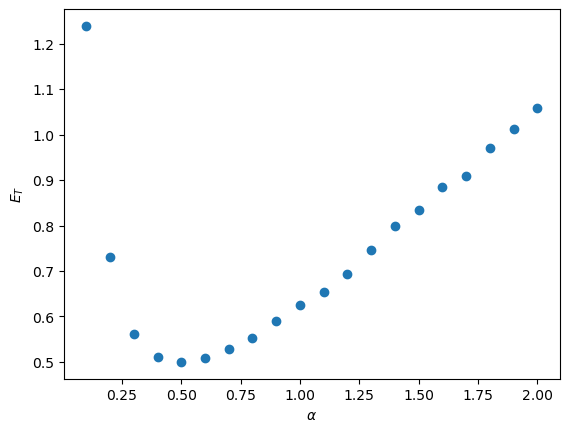

In [11]:
xi_list = []
samples = []
ET = np.zeros(len(a))

for i in range(len(a)):
    xi_list.append(thermalise(a[i], h)) #LIST OF STARTING POSITIONS FOR EACH A
    samples.append(gen_samples(a[i], xi_list[i], h)) #LIST OF SAMPLES FOR EACH A GIVEN STARTING POSITION FOR THAT A

    for j in range(len(samples[i])):
        ET[i] += EL(a[i], samples[i][j]) #SUM LOCAL ENERGIES OF EACH SAMPLE FOR THAT A

    ET[i] = ET[i] / len(samples[i]) #AVERAGE SUM TO GET LOCAL ENERGIES

plt.scatter(a, ET)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$E_T$')

Plotting our results we can see that the minimum value of $E_T$ is 0.5, and occurs at an $\alpha$ value of 0.5. Which corresponds to the analytical solution of the ground state for the 1-dimensional harmonic oscillator.

#### References

1. Sukanta, D. 2014. Variational Monte Carlo Technique: Ground State Energies of Quantum Mechanical Systems. *Resonance*. **19**(8), pp.713-739.